In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import signal

import os
import librosa as lb

import IPython.display as ipd

from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

In [2]:
data_path = './data/labeled_sample/00001073/'

df = pd.read_csv('./data/evaluation.csv')
df.sort_values(by=['audio_file_id'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

patient_id stage_type        audio_file_id  breathing_counts
0        1073    NonREM2  00001073_01_003_002                 1
1        1073    NonREM2  00001073_01_003_003                 5
2        1073    NonREM2  00001073_01_003_004                 3
3        1073    NonREM2  00001073_01_003_005                 2
4        1073    NonREM2  00001073_01_003_006                 2
5        1073    NonREM2  00001073_01_003_007                 4
6        1073    NonREM1  00001073_01_004_001                 6
7        1073    NonREM3  00001073_01_006_010                 3
8        1073        REM  00001073_02_008_008                 4
9        1073        REM  00001073_02_008_009                 4

In [3]:
labels = df['breathing_counts'].values

In [4]:
audio_files = []

for dir_name, _, file_name in os.walk(data_path):
    for file in file_name:
        full_path = os.path.join(dir_name, file)
        audio_files.append(full_path)

audio_files

['./data/labeled_sample/00001073/00001073_01_003_002.wav',
 './data/labeled_sample/00001073/00001073_01_003_003.wav',
 './data/labeled_sample/00001073/00001073_01_003_004.wav',
 './data/labeled_sample/00001073/00001073_01_003_005.wav',
 './data/labeled_sample/00001073/00001073_01_003_006.wav',
 './data/labeled_sample/00001073/00001073_01_003_007.wav',
 './data/labeled_sample/00001073/00001073_01_004_001.wav',
 './data/labeled_sample/00001073/00001073_01_006_010.wav',
 './data/labeled_sample/00001073/00001073_02_008_008.wav',
 './data/labeled_sample/00001073/00001073_02_008_009.wav']

In [5]:
sample_rate = 44100

def load_audio(audio_file):
    output_audio = []
    for file in audio_file:
        audio, _ = lb.load(file, sr=sample_rate)
        output_audio.append(audio)
    return output_audio

audio = load_audio(audio_files)
len(audio)

10

In [6]:
import noisereduce as nr

noise_file = './data/env_noise_02.wav'
noise, _ = lb.load(noise_file, sr=sample_rate)

In [7]:
# upper_cutoff = 15000
# cutoff_freq = [1000, upper_cutoff]

high_pass = signal.firwin(101, 1000, pass_zero= 'highpass', fs=sample_rate)

def apply_high_pass_filter(sig_array):
    return signal.lfilter(high_pass, [1.0], sig_array)

# y_noise=noise,

def apply_noise_reduction(sig_array):
    return nr.reduce_noise(y=sig_array, sr=sample_rate, y_noise=noise, stationary=True)

def apply_log_compression(sig_array, gamma):
    sign = np.sign(sig_array)
    abs_signal = 1 + np.abs(sig_array) * gamma
    logged = np.log(abs_signal)
    scaled = logged * (1 / np.log(1.0 + gamma))
    return sign * scaled

def nomalize_volume(sig_array):
    minAmp, maxAmp = np.amin(sig_array), np.amax(sig_array)
    max_energy = max(abs(minAmp), abs(maxAmp))
    scale = 1.0 / max_energy
    sig_array *= scale
    return sig_array

noise_removed = []

for sig in audio:
    # sig = apply_high_pass_filter(sig)
    sig = apply_noise_reduction(sig)
    sig = apply_log_compression(sig, 100)
    sig = nomalize_volume(sig)
    noise_removed.append(sig)

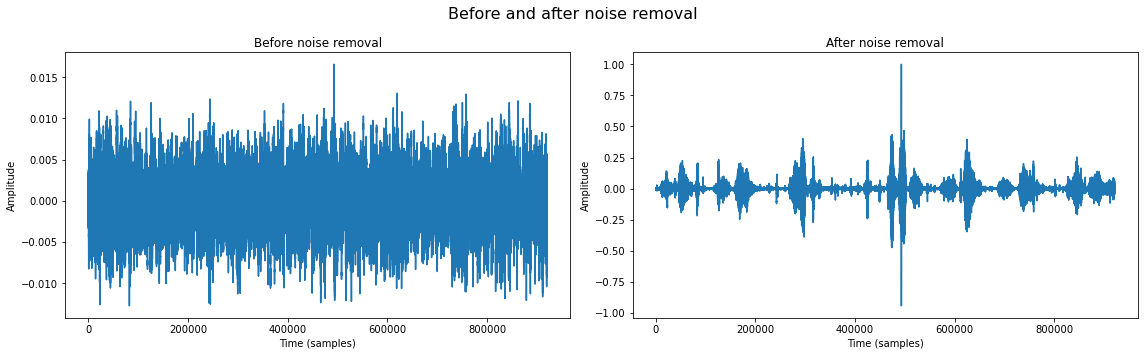

Before noise removal:  (920783,)


After noise removal:  (920783,)


In [8]:


fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sample_idx = 6

fig.suptitle('Before and after noise removal', fontsize=16)

axs[0].plot(audio[sample_idx])
axs[0].set_title('Before noise removal')

axs[1].plot(noise_removed[sample_idx])
axs[1].set_title('After noise removal')

for ax in axs:
    ax.set_xlabel('Time (samples)')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

print('Before noise removal: ', audio[sample_idx].shape)
ipd.display(ipd.Audio(audio[sample_idx], rate=sample_rate))
print('After noise removal: ', noise_removed[sample_idx].shape)
ipd.display(ipd.Audio(noise_removed[sample_idx], rate=sample_rate))

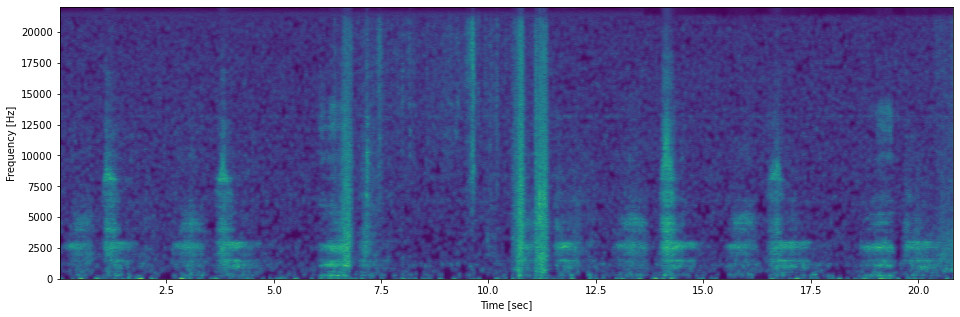

In [9]:
window_size_sec = 0.05
window_size = int(window_size_sec * sample_rate)

def plot_spectrogram(sig_array):
    plt.subplots(figsize=(16, 5))
    plt.pcolormesh(sig_array[1], sig_array[0], np.power(sig_array[2], 0.1), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

def get_spectrogram(sig_array):
    spectrogrmas = []
    for sig in sig_array:
        f, t, Sxx = signal.spectrogram(sig, sample_rate, nperseg=window_size)
        spectrogrmas.append((f, t, Sxx))
    return spectrogrmas

spectrograms = get_spectrogram(noise_removed)
plot_spectrogram(spectrograms[sample_idx])

In [10]:
breathing_counts = df['breathing_counts']

In [11]:
def get_envelope(spectrogram):
    times = []
    power_envelope = []
    for spec in spectrogram:
        times.append(spec[1])
        power_envelope.append(gaussian_filter1d(np.sum(spec[2], axis=0), sigma=10))
    return times, power_envelope

In [12]:
def get_peaks_idx(power_envelope):
    peaks, _ = find_peaks(power_envelope, height=0.00008)
    return peaks

In [13]:
def get_peak_timing(time, power_envelope):
    peaks = get_peaks_idx(power_envelope)
    peak_timing = []
    for peak in peaks:
        peak_timing.append(time[peak])
    return peak_timing

In [14]:
def peak_plot(power_envelope, time, peaks_idx, breathing_count):
    peak_timing = [time[peak] for peak in peaks_idx]
    plt.subplots(figsize=(16, 5))
    plt.plot(time, power_envelope, color='gray')
    plt.plot(peak_timing, power_envelope[peaks_idx], "v", color='red', markersize=10)
    plt.hlines(y=0.00008, xmin=0, xmax=time[-1], color='red', linestyles='dashed')
    plt.ylabel('Power')
    plt.xlabel('Time [sec]')
    plt.title('Power envelope with breathing count: {}'.format(breathing_count))
    plt.show()

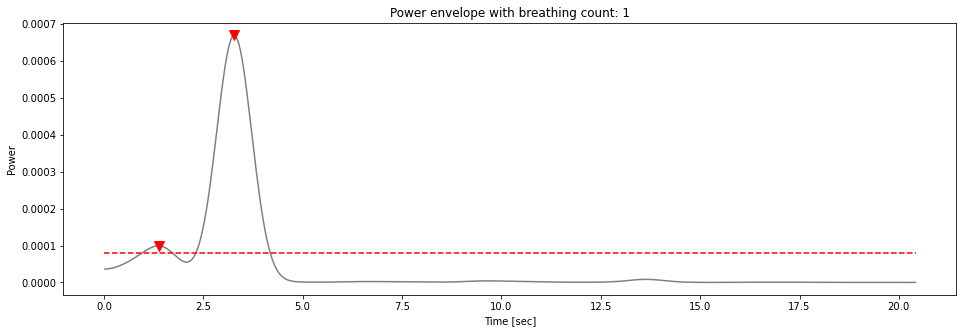

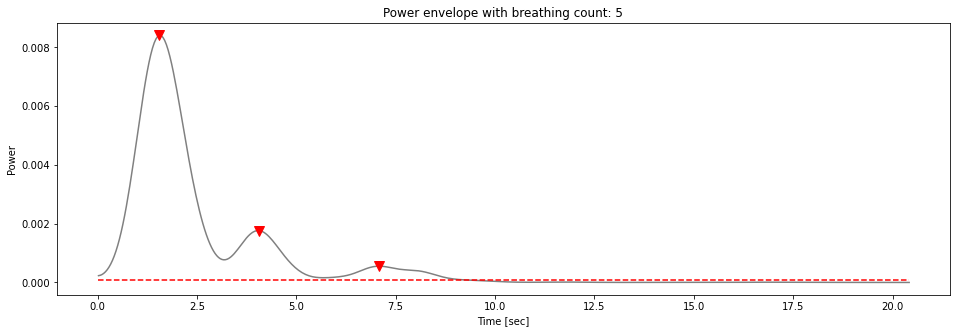

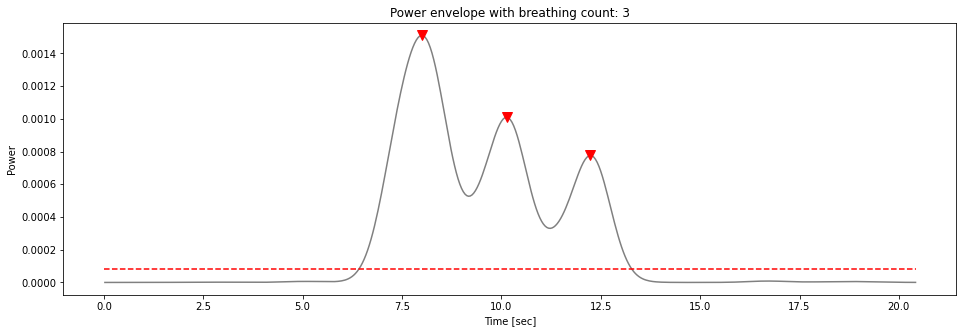

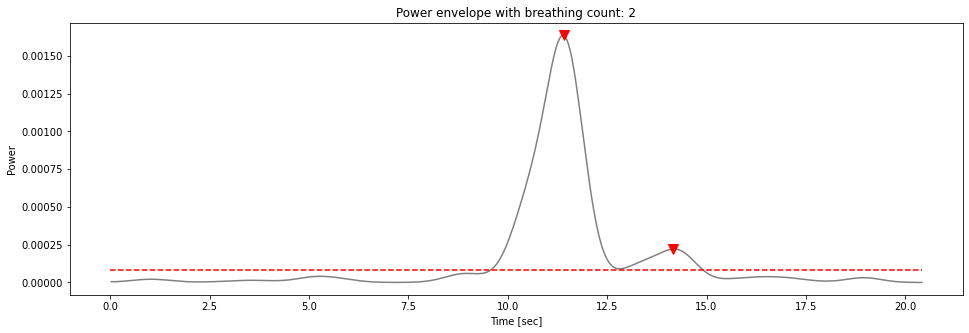

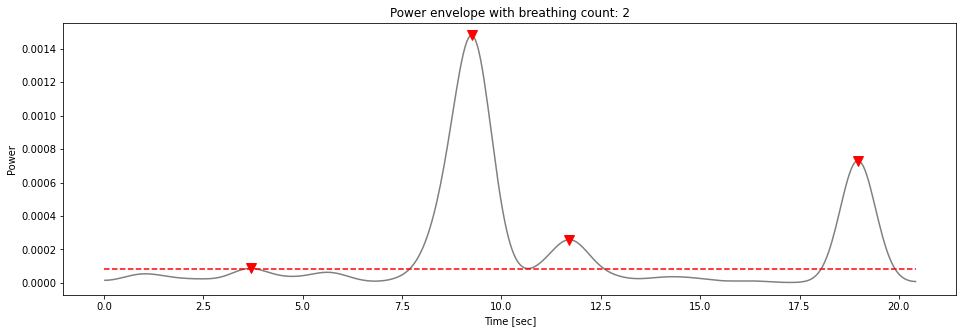

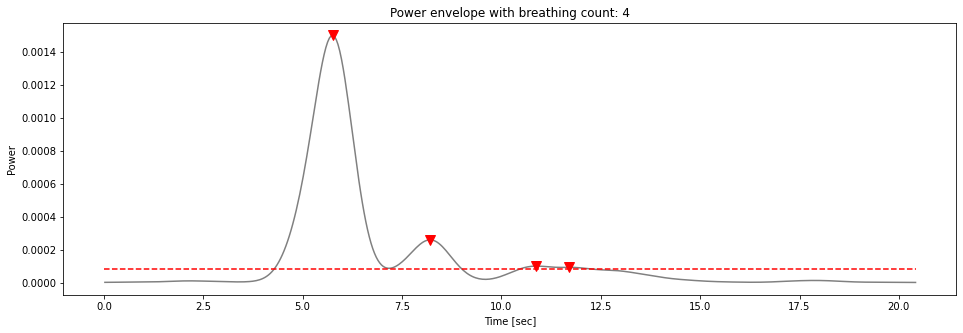

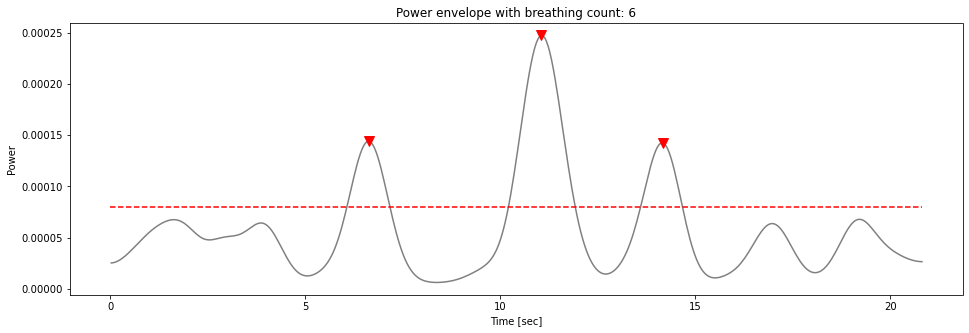

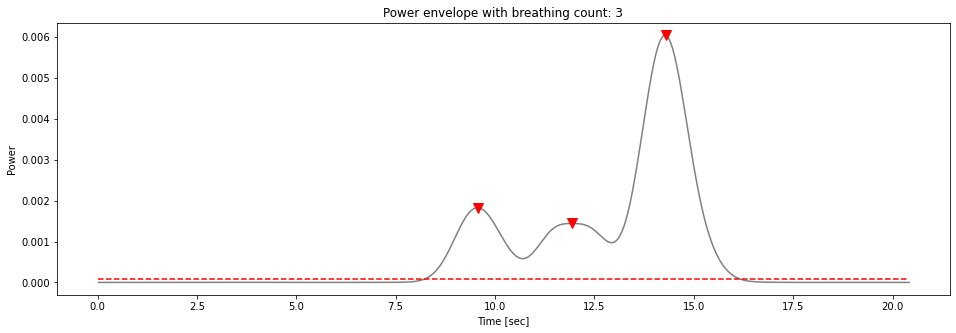

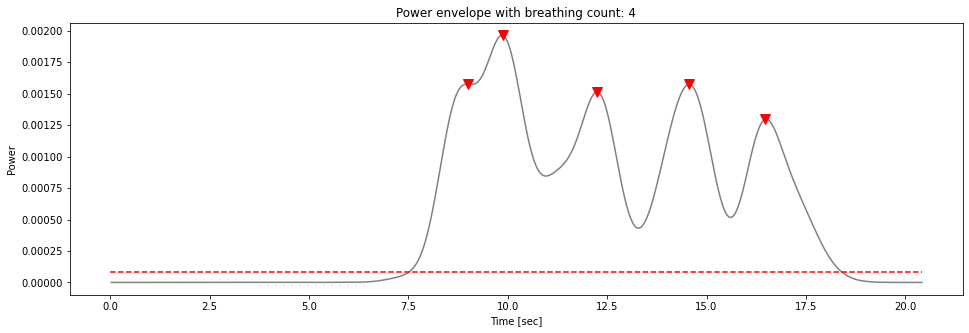

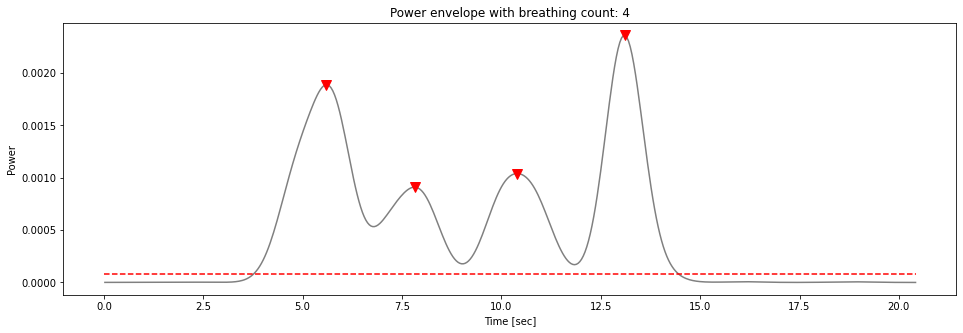

In [15]:
times, power_envelopes = get_envelope(spectrograms)
peak_counts = []

for i in range(len(times)):
    peaks_idx = get_peaks_idx(power_envelopes[i])
    peak_plot(power_envelopes[i], times[i], peaks_idx, breathing_counts[i])
    peak_counts.append(len(peaks_idx))

In [16]:
df

patient_id stage_type        audio_file_id  breathing_counts
0        1073    NonREM2  00001073_01_003_002                 1
1        1073    NonREM2  00001073_01_003_003                 5
2        1073    NonREM2  00001073_01_003_004                 3
3        1073    NonREM2  00001073_01_003_005                 2
4        1073    NonREM2  00001073_01_003_006                 2
5        1073    NonREM2  00001073_01_003_007                 4
6        1073    NonREM1  00001073_01_004_001                 6
7        1073    NonREM3  00001073_01_006_010                 3
8        1073        REM  00001073_02_008_008                 4
9        1073        REM  00001073_02_008_009                 4

In [17]:
peak_counts

[2, 3, 3, 2, 4, 4, 3, 3, 5, 4]

In [18]:
new_df = pd.concat([df, pd.DataFrame(peak_counts, columns=['peak_detected'])], axis=1)

In [19]:
new_df

patient_id stage_type        audio_file_id  breathing_counts  peak_detected
0        1073    NonREM2  00001073_01_003_002                 1              2
1        1073    NonREM2  00001073_01_003_003                 5              3
2        1073    NonREM2  00001073_01_003_004                 3              3
3        1073    NonREM2  00001073_01_003_005                 2              2
4        1073    NonREM2  00001073_01_003_006                 2              4
5        1073    NonREM2  00001073_01_003_007                 4              4
6        1073    NonREM1  00001073_01_004_001                 6              3
7        1073    NonREM3  00001073_01_006_010                 3              3
8        1073        REM  00001073_02_008_008                 4              5
9        1073        REM  00001073_02_008_009                 4              4

In [20]:
# mean absolute error between peak counts and breathing counts

from sklearn.metrics import mean_absolute_error

mean_absolute_error(new_df['breathing_counts'], new_df['peak_detected'])

0.9